In [25]:
import torch 
from torch import nn 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split

In [26]:
from helper_functions import plot_decision_boundary

In [27]:
#creating an evaluation metric <- accuracy man 
def accuracy_fn(y_true , y_pred):
    correct = torch.eq(y_pred , y_true).sum().item()
    acc = (correct/len(y_pred)) * 100 
    return acc

In [59]:
#hyperparameters 
NUM_CLASSES = 4 
NUM_FEATURES = 2 
RANDOM_SEED = 42

#creating multiclass data 
X_blob , y_blob = make_blobs(n_samples=1000 , 
                             n_features=NUM_FEATURES , 
                             centers = NUM_CLASSES , 
                             cluster_std=1.5 , 
                             random_state= RANDOM_SEED)
X_blob[:10], y_blob[:10]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475],
        [-6.7941075 , -6.47722117],
        [ 5.21017561,  2.8890483 ],
        [-5.50513568, -6.36037688],
        [-6.54375599, -4.83389895],
        [ 6.44964229,  0.74776618]]),
 array([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]))

In [60]:
X_blob , y_blob = torch.from_numpy(X_blob).type(torch.float) , torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob[:5] , y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

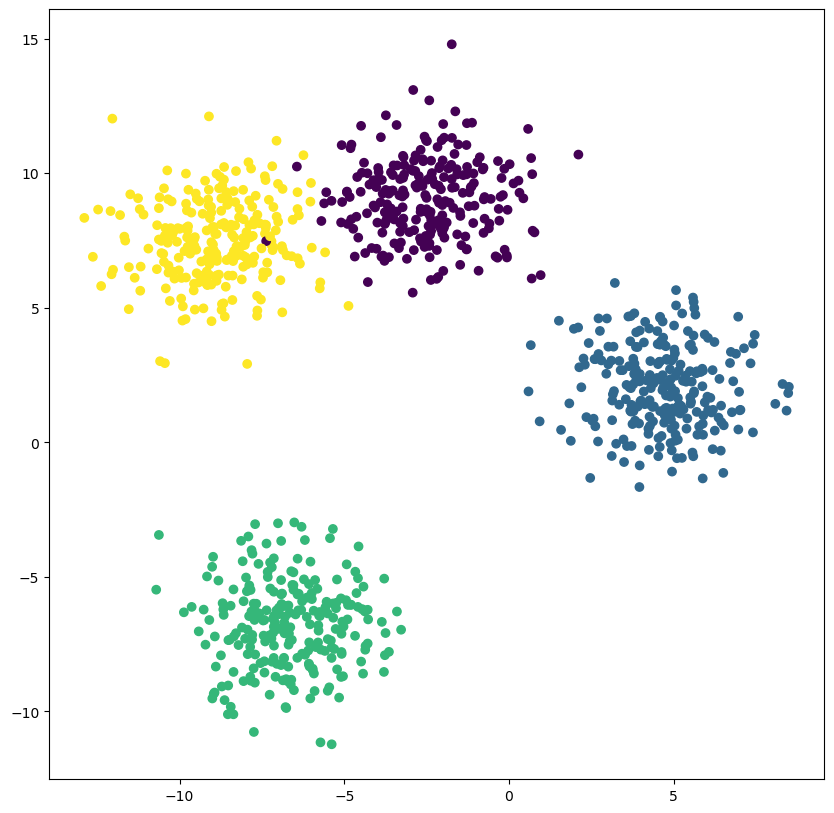

In [61]:
# splitting the data 
X_blob_train , X_blob_test , y_blob_train , y_blob_test = train_test_split(X_blob , 
                                                                           y_blob , 
                                                                           test_size=0.2 , 
                                                                           random_state=RANDOM_SEED)
plt.figure(figsize=(10,10))
plt.scatter(X_blob[: , 0] , X_blob[: , 1] , c = y_blob)

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [63]:
#building out the model 
class BlobModelv0(nn.Module):
    def __init__(self , input_features , output_features , hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features , out_features=hidden_units) ,
            nn.ReLU(),
            nn.Linear(in_features=hidden_units , out_features=hidden_units), 
            nn.ReLU(),
            nn.Linear(in_features=hidden_units , out_features=output_features)
        )
    
    def forward(self , x):
        return self.linear_layer_stack(x)

model = BlobModelv0(input_features=NUM_FEATURES , 
                    output_features=NUM_CLASSES , 
                    hidden_units= 8).to(device)
model
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters() , 
                            lr = 0.1)


# model(X_blob_train.to(device))[0].shape , NUM_CLASSES
# y_logits = model(X_blob_test.to(device))

# #softmax calculation 
# y_preds_prob = torch.softmax(y_logits , dim = 1)
# print(y_logits[:5])
# print(y_preds_prob[:5])
# y_preds_prob[0].argmax()
# torch.sum(y_preds_prob[0])
# print(torch.argmax(y_preds_prob[2]))


#Training💪 and testing🧪 loop
torch.manual_seed(42)

#Set number of epochs 
epochs = 100 

X_blob_train , y_blob_train = X_blob_train.to(device) , y_blob_train.to(device)
X_blob_test , y_blob_test = X_blob_test.to(device) , y_blob_test.to(device) 

for epoch in range(epochs):

    model.train()

    y_logits = model(X_blob_train)
    y_preds = torch.softmax(y_logits , dim = 1).argmax(dim = 1)

    loss = loss_func(y_logits , y_blob_train )
    acc = accuracy_fn(y_preds , y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #evaluation
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits , dim = 1).argmax(dim = 1)

        test_loss = loss_func(test_logits , y_blob_test)
        test_acc = accuracy_fn(test_pred , y_blob_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


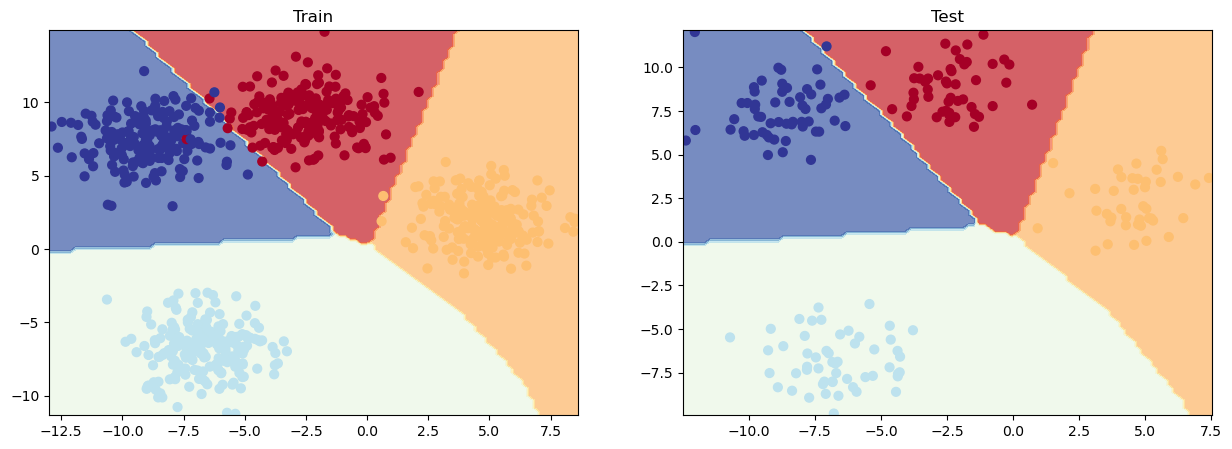

In [68]:
#decision boundary
plt.figure(figsize=(15 , 5))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model , X_blob_train , y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model , X_blob_test , y_blob_test)

In [76]:
#other accuracy scores
try: 
    from torchmetrics import Accuracy 
except:
    !pip install torchmetrics 
    from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = 'multiclass' , num_classes = 4).to(device)
torchmetrics_accuracy(test_pred , y_blob_test)

tensor(0.9950, device='cuda:0')